In [3]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing

import pandas as pd
import os
import numpy as np
import time
import datetime

##matrix math
import math


os.chdir('D:/Graduate Courses/2019 Dissertation/Data/Other.coins')
print("Current Working Directory " , os.getcwd())


Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [4]:
# %load LSTM2
#!/usr/bin/env python

# In[1]:


def load_data(filename, window_length,percent):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    percent -- how many percent of data used to train the model
    
    Returns:
    if window=30
    X_train -- A tensor of shape (2492, 30, 105) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2492,) that will be inputed into the model to train it
    X_test -- A tensor of shape (623, 30, 105) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (623,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (623,) that represents the price of bitcoin the day before each Y_test value
    """
    
    #Read the data file
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'])
    dataset_total=dataset_total.drop(['Unnamed: 0',], axis=1)

    # Set index
    dataset_total.set_index('Date', inplace=True)
    dataset_total= dataset_total.loc[:, (dataset_total!= 0).any(axis=0)]

    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    Y=dataset_total_scaled[:,-1]
    
   
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    data = X_normal.tolist()
    result = []
    for index in range(len(data) - window_length):
        result.append(data[index: index + window_length])

    data_reshape=np.array(result)
    data_reshape.shape

    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent* data_reshape.shape[0])
    X_train = data_reshape[:int(split_line), :]
    Y_train = Y[window_length:int(split_line)+window_length]
    X_test = data_reshape[int(split_line):,:]
    Y_test = Y[int(split_line)+window_length:]
    Y_daybefore = Y[int(split_line)+window_length-1:-1]
   
    #new
    line=int(split_line)+window_length
    return X_train, Y_train, X_test, Y_test, window_length,dataset_total,Y_daybefore,line


def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()

    input_shape=(window_length, X_train.shape[-1])

    optimizer='adam'
    loss='mean_squared_error'
    
    model.add(LSTM(units = 32, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units = 1))
    model.compile(optimizer =optimizer, loss = loss)

    
    return model


#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model


# test the model
def test_model(model, X_test, Y_test):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (623, 30, 105) that represents the x values of the testing data
    Y_test -- A tensor of shape (623,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (623,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (623,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (623,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (623,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    Y_norm = model.predict(X_test)
    
    # normalize predicted y
    Y_original=dataset_total.iloc[:,-1]
    Y_max=Y_original.max()
    Y_min=Y_original.min()
    real_y_predict = Y_norm *(Y_max-Y_min)+Y_min
    
    # normalize Y_test
    real_y_test = Y_test *(Y_max-Y_min)+Y_min
    
    # normalize real Y_daybefore
    real_y_daybefore = Y_daybefore * (Y_max-Y_min)+Y_min

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Real and Predicted Return Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Return')
    plt.plot(real_y_test, color = 'red', label = 'Real Return')
    ax.set_ylabel("Return")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    plt.style.use('ggplot')
    plt.show()
    return Y_norm, real_y_test, real_y_predict, fig, real_y_daybefore


#evaluate change in return

def return_change(real_y_daybefore, real_y_test, real_y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    real_y_daybefore -- A tensor of shape (623,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (623,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (623,) that represents the normalized y values of the model's predictions
    
    Returns:
    delta_predict -- A tensor of shape (623, ) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (623, ) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    return_change_real = real_y_test - real_y_daybefore
    real_y_predict_reshape= np.reshape(real_y_predict,(real_y_predict.shape[0],))
    return_change_predict = real_y_predict_reshape - real_y_daybefore

    fig_2 = plt.figure(figsize=(10, 6))
    ax = fig_2.add_subplot(111)
    ax.set_title("Change in Real and Predicted Return Per Day")
    plt.plot(return_change_predict, color='green', label = 'Predicted Return Change')
    plt.plot(return_change_real, color='red', label = 'Real Return Change')
    plt.ylabel("Return Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.style.use('ggplot')
    plt.show()
    return  return_change_predict, return_change_real, fig_2

def binary_return(return_change_predict,return_change_real):
    """
    Converts return change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (623, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (623, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    return_change_predict_1_0 = np.empty(return_change_predict.shape)
    return_change_real_1_0 = np.empty(return_change_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(return_change_predict.shape[0]):
        if return_change_predict[i] > 0:
            return_change_predict_1_0[i] = 1
        else:
            return_change_predict_1_0[i] = 0
  
    for i in range(return_change_real.shape[0]):
        if  return_change_real[i] > 0:
            return_change_real_1_0[i] = 1
        else:
            return_change_real_1_0[i] = 0
    return return_change_predict_1_0, return_change_real_1_0


def find_positives_negatives(return_change_predict_1_0, return_change_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(return_change_real_1_0.shape[0]):
        real = return_change_real_1_0[i]
        predicted = return_change_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg


# In[ ]:

def find_win_ratio(predict_range):
    #win='win_'+str(int(predict_range))
    #lose='win_'+str(int(predict_range))
    win=0
    lose=0
    no_predict=0
    for i in range(classification.shape[0]):
            if classification['real_y_test_range'][i]<0 and classification['real_y_predict_range'][i]==predict_range:
                win+=1
            elif classification['real_y_test_range'][i]>=0 and classification['real_y_predict_range'][i]==predict_range:
                lose+=1
    win_ratio=win/int(frequency_counts.loc[predict_range,:])
    win_ratio=round(win_ratio,4)
    #print('The win number of predicted range '+str(int(predict_range))+" is "+str(win))
    print('The win ratio of predicted range '+str(int(predict_range))+" is "+str(win_ratio))
    
    return win, lose, win_ratio





(396, 30, 98)
(396,)
(180, 30, 98)
(180,)
30
(180,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 32)            16768     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 25,121
Trainable para

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 277 samples, validate on 119 samples
Epoch 1/100
277/277 [==============================] - 1s 5ms/step - loss: 0.1559 - val_loss: 0.0481
Epoch 2/100
277/277 [==============================] - 0s 666us/step - loss: 0.0376 - val_loss: 0.0112
Epoch 3/100
277/277 [==============================] - 0s 703us/step - loss: 0.0351 - val_loss: 0.0089
Epoch 4/100
277/277 [==============================] - 0s 702us/step - loss: 0.0322 - val_loss: 0.0097
Epoch 5/100
277/277 [==============================] - 0s 729us/step - loss: 0.0290 - val_loss: 0.0058
Epoch 6/100
277/277 [==============================] - 0s 713us/step - loss: 0.0264 - val_loss: 0.0075
Epoch 7/100
277/277 [==============================] - 0s 662us/step - loss: 0.0254 - val_loss: 0.0075
Epoch 8/100
277/277 [==============================] - 0s 668us/step - loss: 0.0239 - val_loss: 0.0069
Epoch 9/100
277/277 [==============================] - 0s 572us/step - loss: 0.0250 - val_loss: 0.0079
Epoch 10/100
277/277 [=======

277/277 [==============================] - 0s 727us/step - loss: 0.0209 - val_loss: 0.0101
Epoch 80/100
277/277 [==============================] - 0s 689us/step - loss: 0.0200 - val_loss: 0.0082
Epoch 81/100
277/277 [==============================] - 0s 705us/step - loss: 0.0198 - val_loss: 0.0097
Epoch 82/100
277/277 [==============================] - 0s 745us/step - loss: 0.0201 - val_loss: 0.0084
Epoch 83/100
277/277 [==============================] - 0s 715us/step - loss: 0.0211 - val_loss: 0.0100
Epoch 84/100
277/277 [==============================] - 0s 634us/step - loss: 0.0198 - val_loss: 0.0099
Epoch 85/100
277/277 [==============================] - 0s 641us/step - loss: 0.0198 - val_loss: 0.0086
Epoch 86/100
277/277 [==============================] - ETA: 0s - loss: 0.017 - 0s 634us/step - loss: 0.0191 - val_loss: 0.0076
Epoch 87/100
277/277 [==============================] - 0s 583us/step - loss: 0.0193 - val_loss: 0.0100
Epoch 88/100
277/277 [==============================]

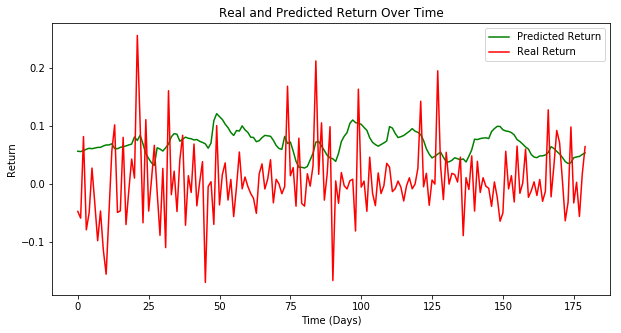

In [5]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_EOS-USD.csv", 30, 0.6880)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

In [6]:
def classify_range(variable_name):
    
    classification[variable_name+'_range']=0

    for i in range(classification.shape[0]):
        if classification[variable_name][i]<=0.002 and classification[variable_name][i]>=-0.002:
            classification[variable_name+'_range'][i]=0
        
        elif classification[variable_name][i]<=-0.002 and classification[variable_name][i]>=-0.004:
            classification[variable_name+'_range'][i]=-1
        
        elif classification[variable_name][i]<=-0.004 and classification[variable_name][i]>=-0.006:
            classification[variable_name+'_range'][i]=-2
        
        elif classification[variable_name][i]<=-0.006 and classification[variable_name][i]>=-0.008:
            classification[variable_name+'_range'][i]=-3
        
        elif classification[variable_name][i]<=-0.008 and classification[variable_name][i]>=-0.010:
            classification[variable_name+'_range'][i]=-4
        
        elif classification[variable_name][i]<=-0.010 and classification[variable_name][i]>=-0.012:
            classification[variable_name+'_range'][i]=-5
        
        elif classification[variable_name][i]<=-0.012 and classification[variable_name][i]>=-0.014:
            classification[variable_name+'_range'][i]=-6
        
        elif classification[variable_name][i]<=-0.014 and classification[variable_name][i]>=-0.016:
            classification[variable_name+'_range'][i]=-7
        
        elif classification[variable_name][i]<=-0.016 and classification[variable_name][i]>=-0.018:
            classification[variable_name+'_range'][i]=-8
        
        elif classification[variable_name][i]<=-0.018 and classification[variable_name][i]>=-0.020:
            classification[variable_name+'_range'][i]=-9
        
        elif classification[variable_name][i]<=-0.020:
            classification[variable_name+'_range'][i]=-10
        
        #positive value
        elif classification[variable_name][i]<=0.004 and classification[variable_name][i]>=0.002:
            classification[variable_name+'_range'][i]=1
        
        elif classification[variable_name][i]<=0.006 and classification[variable_name][i]>=0.004:
            classification[variable_name+'_range'][i]=2
        
        elif classification[variable_name][i]<=0.008 and classification[variable_name][i]>=0.006:
            classification[variable_name+'_range'][i]=3
        
        elif classification[variable_name][i]<=0.010 and classification[variable_name][i]>=0.008:
            classification[variable_name+'_range'][i]=4
        
        elif classification[variable_name][i]<=0.012 and classification[variable_name][i]>=0.010:
            classification[variable_name+'_range'][i]=5
        
        elif classification[variable_name][i]<=0.014 and classification[variable_name][i]>=0.012:
            classification[variable_name+'_range'][i]=6
        
        elif classification[variable_name][i]<=0.016 and classification[variable_name][i]>=0.014:
            classification[variable_name+'_range'][i]=7
        
        elif classification[variable_name][i]<=0.018 and classification[variable_name][i]>=0.016:
            classification[variable_name+'_range'][i]=8
        
        elif classification[variable_name][i]<=0.020 and classification[variable_name][i]>=0.018:
            classification[variable_name+'_range'][i]=9
         
        else:
            classification[variable_name+'_range'][i]=10
    return classification

def find_the_successful_rate(classification):
    successful_number=0
    for i in range(classification.shape[0]):
        if classification['real_y_test_range'][i]==classification['real_y_predict_range'][i]:
            successful_number+=1
    successful_rate=round(successful_number/classification.shape[0],4)
    return successful_rate


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25     0.038930       -0.023011                 10   
2018-11-26    -0.054833       -0.021143                -10   
2018-11-27     0.010146       -0.028488                  5   
2018-11-28     0.115240       -0.017757                 10   
2018-11-29     0.005427        0.000440                  2   
2018-11-30    -0.064623       -0.001801                -10   
2018-12-01     0.046834       -0.016975                 10   
2018-12-02    -0.012770       -0.006288                 -6   
2018-12-03    -0.065748       -0.003252                -10   
2018-12-04     0.019897       -0.023063                  9   
2018-12-05    -0.053416       -0.011032                -10   
2018-12-06    -0.067518       -0.029096                -10   
2018-12-07    -0.018538       -0.023691                 -9   
2018-12-08     0.011840       -0.019271                  5   
2018-12-

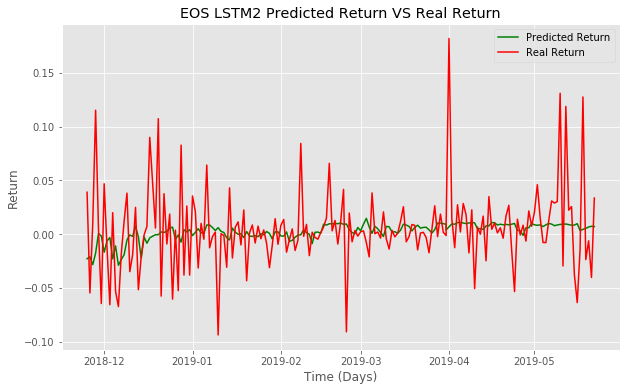

The win ratio of predicted range -10 is 0.5714
The win ratio of predicted range -9 is 0.0
The win ratio of predicted range -8 is 0.0
The win ratio of predicted range -5 is 1.0
The win ratio of predicted range -4 is 0.0
The win ratio of predicted range -3 is 0.6667
The win ratio of predicted range -2 is 0.2
The win ratio of predicted range -1 is 0.4545
The win ratio of predicted range 0 is 0.4
The win ratio of predicted range 1 is 0.4118
The win ratio of predicted range 2 is 0.4444
The win ratio of predicted range 3 is 0.55
The win ratio of predicted range 4 is 0.325
The win ratio of predicted range 5 is 0.25
The win ratio of predicted range 7 is 1.0


In [13]:
classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)
print(successful_rate)

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("EOS LSTM2 Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

frequency_counts=pd.DataFrame(classification['real_y_predict_range'].value_counts(),index=None)
frequency_counts.columns=['Frequency']

#win_8,lose_8,win_ratio_8=find_win_ratio(8)    
#win_9,lose_9,win_ratio_9=find_win_ratio(9)    
#win_10,lose_10,win_ratio_10=find_win_ratio(10)    

for i in range(-10,11):
    try:
        find_win_ratio(i)
    except:
        pass

(1088, 30, 110)
(1088,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 26,657
Trainable params: 26,657
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 761 samples, validate on 327 samples
Epoch 1/100
761/761 [==============================] - 2s 3ms/step - loss: 0.0333 - val_loss: 0.0065
Epoch 2/100
761/761 [==============================] - 1s 681us/step - loss: 0.0155 - val_loss: 0.0056
Epoch 3/100
761/761 [==============================] - 1s 698us/step - loss: 0.0124 - val_loss: 0.0056
Epoch 4/100
761/761 [==============================] - 1s 689us/step - loss: 0.0122 - val_loss: 0.0057
Epoch 5/100
761/761 [==============================] - 0s 653us/step - loss: 0.0118 - val_loss: 0.0056
Epoch 6/100
761/761 [==============================] - 1s 666us/step - loss: 0.0119 - val_loss: 0.0057
Epoch 7/100
761/761 [==============================] - 0s 635us/step - loss: 0.0130 - val_loss: 0.0056
Epoch 8/100
761/761 [==============================] - 1s 699us/step - loss: 0.0113 - val_loss: 0.0055
Epoch 9/100
761/761 [==============================] - 1s 676us/step - loss: 0.0119 - val_loss: 0.0058
Epoch 10/100
761/761 [=======

761/761 [==============================] - 1s 671us/step - loss: 0.0098 - val_loss: 0.0076
Epoch 80/100
761/761 [==============================] - 1s 722us/step - loss: 0.0097 - val_loss: 0.0068
Epoch 81/100
761/761 [==============================] - 1s 710us/step - loss: 0.0094 - val_loss: 0.0070
Epoch 82/100
761/761 [==============================] - 1s 708us/step - loss: 0.0097 - val_loss: 0.0062
Epoch 83/100
761/761 [==============================] - 1s 664us/step - loss: 0.0093 - val_loss: 0.0063
Epoch 84/100
761/761 [==============================] - 1s 711us/step - loss: 0.0093 - val_loss: 0.0064
Epoch 85/100
761/761 [==============================] - 0s 653us/step - loss: 0.0093 - val_loss: 0.0068
Epoch 86/100
761/761 [==============================] - 0s 657us/step - loss: 0.0092 - val_loss: 0.0067
Epoch 87/100
761/761 [==============================] - 1s 660us/step - loss: 0.0090 - val_loss: 0.0067
Epoch 88/100
761/761 [==============================] - 1s 700us/step - loss:

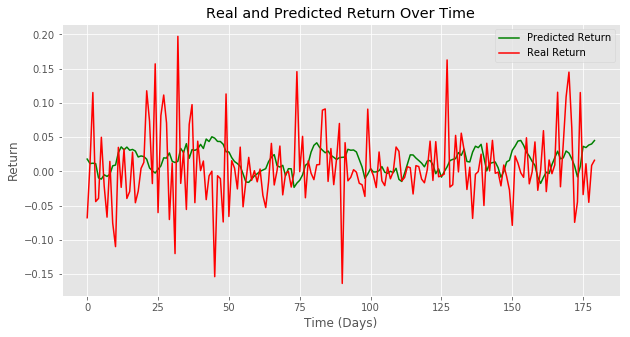

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.067495        0.018065                -10   
2018-11-26     0.012125        0.011522                  6   
2018-11-27     0.115165        0.012030                 10   
2018-11-28    -0.043945        0.011407                -10   
2018-11-29    -0.039241       -0.009437                -10   
2018-11-30     0.049880       -0.011118                 10   
2018-12-01    -0.021435       -0.004859                -10   
2018-12-02    -0.066661       -0.007216                -10   
2018-12-03     0.014691       -0.004232                  7   
2018-12-04    -0.075123        0.008231                -10   
2018-12-05    -0.109678        0.009349                -10   
2018-12-06     0.035165        0.027466                 10   
2018-12-07    -0.023181        0.035884                -10   
2018-12-08     0.032590        0.031638                 10   
2018-12-

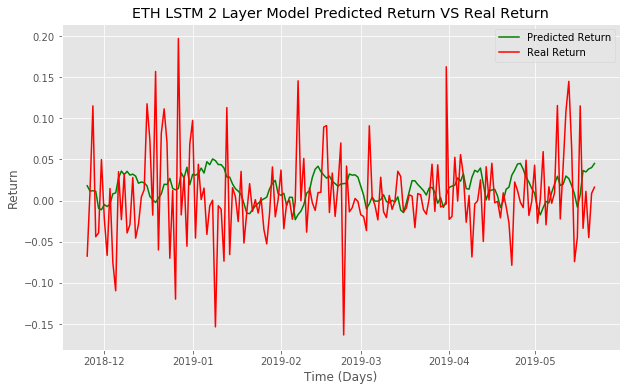

The win ratio of predicted range -10 is 0.0
The win ratio of predicted range -8 is 0.0
The win ratio of predicted range -7 is 0.6667
The win ratio of predicted range -6 is 0.0
The win ratio of predicted range -5 is 0.5
The win ratio of predicted range -4 is 0.8
The win ratio of predicted range -3 is 0.75
The win ratio of predicted range -2 is 0.3333
The win ratio of predicted range -1 is 0.375
The win ratio of predicted range 0 is 0.5833
The win ratio of predicted range 1 is 1.0
The win ratio of predicted range 2 is 0.1667
The win ratio of predicted range 3 is 0.5
The win ratio of predicted range 4 is 0.5714
The win ratio of predicted range 5 is 0.5714
The win ratio of predicted range 6 is 0.5
The win ratio of predicted range 7 is 0.3333
The win ratio of predicted range 8 is 0.5
The win ratio of predicted range 9 is 0.2222
The win ratio of predicted range 10 is 0.4521


In [8]:
#Compile together
#ETH 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_ETH-USD.csv", 30, 0.8582)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("ETH LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

frequency_counts=pd.DataFrame(classification['real_y_predict_range'].value_counts(),index=None)
frequency_counts.columns=['Frequency']

#win_8,lose_8,win_ratio_8=find_win_ratio(8)    
#win_9,lose_9,win_ratio_9=find_win_ratio(9)    
#win_10,lose_10,win_ratio_10=find_win_ratio(10)    

for i in range(-10,11):
    try:
        find_win_ratio(i)
    except:
        pass

(1740, 30, 108)
(1740,)
(180, 30, 108)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 32)            18048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 26,401
Trainable params: 26,401
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1218 samples, validate on 522 samples
Epoch 1/100
1218/1218 [==============================] - 2s 2ms/step - loss: 0.0111 - val_loss: 0.0017
Epoch 2/100
1218/1218 [==============================] - 1s 576us/step - loss: 0.0041 - val_loss: 0.0027
Epoch 3/100
1218/1218 [==============================] - 1s 585us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 4/100
1218/1218 [==============================] - 1s 655us/step - loss: 0.0028 - val_loss: 0.0014
Epoch 5/100
1218/1218 [==============================] - 1s 637us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 6/100
1218/1218 [==============================] - 1s 632us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/100
1218/1218 [==============================] - 1s 629us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 8/100
1218/1218 [==============================] - 1s 625us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 9/100
1218/1218 [==============================] - 1s 616us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 10/1

Epoch 78/100
1218/1218 [==============================] - 1s 613us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 79/100
1218/1218 [==============================] - 1s 635us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 80/100
1218/1218 [==============================] - 1s 691us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 81/100
1218/1218 [==============================] - 1s 656us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 82/100
1218/1218 [==============================] - 1s 681us/step - loss: 0.0013 - val_loss: 0.0023
Epoch 83/100
1218/1218 [==============================] - 1s 635us/step - loss: 0.0013 - val_loss: 0.0025
Epoch 84/100
1218/1218 [==============================] - 1s 702us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 85/100
1218/1218 [==============================] - 1s 638us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 86/100
1218/1218 [==============================] - 1s 675us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 87/100
1218/1218 [======================

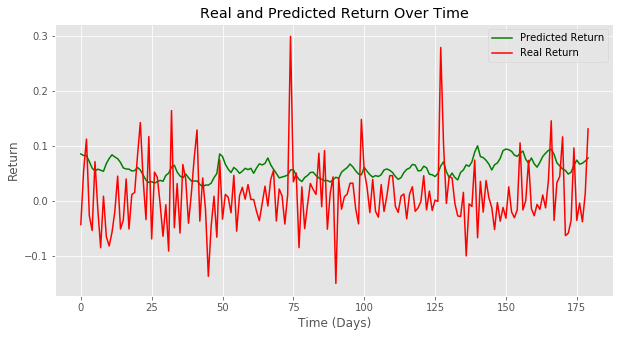

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.043450        0.085299                -10   
2018-11-26     0.055254        0.082494                 10   
2018-11-27     0.112432        0.082336                 10   
2018-11-28    -0.027433        0.071418                -10   
2018-11-29    -0.054335        0.059435                -10   
2018-11-30     0.071272        0.054094                 10   
2018-12-01    -0.015826        0.057587                 -7   
2018-12-02    -0.085765        0.055660                -10   
2018-12-03     0.008143        0.053637                  4   
2018-12-04    -0.065590        0.067699                -10   
2018-12-05    -0.082642        0.076974                -10   
2018-12-06    -0.057671        0.083773                -10   
2018-12-07    -0.020000        0.079771                 -9   
2018-12-08     0.044898        0.076631                 10   
2018-12-

C:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


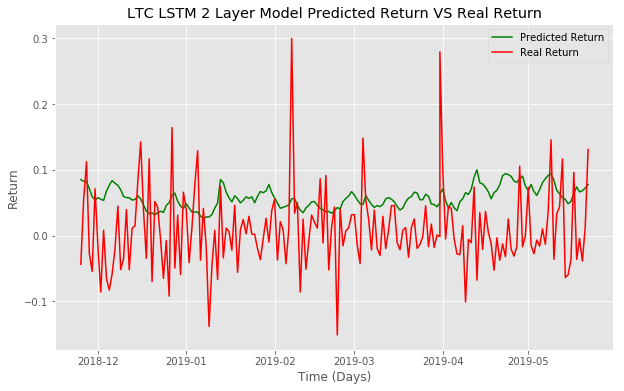

The win ratio of predicted range 10 is 0.4778


In [7]:
#Compile together
#LTC
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_LTC-USD.csv", 30, 0.9063)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("LTC LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

frequency_counts=pd.DataFrame(classification['real_y_predict_range'].value_counts(),index=None)
frequency_counts.columns=['Frequency']

#win_8,lose_8,win_ratio_8=find_win_ratio(8)    
#win_9,lose_9,win_ratio_9=find_win_ratio(9)    
#win_10,lose_10,win_ratio_10=find_win_ratio(10)    

for i in range(-10,11):
    try:
        find_win_ratio(i)
    except:
        pass

(1286, 30, 110)
(1286,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 26,657
Trainable params: 26,657
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 386 samples
Epoch 1/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0159 - val_loss: 0.0036
Epoch 2/100
900/900 [==============================] - 1s 690us/step - loss: 0.0065 - val_loss: 0.0025
Epoch 3/100
900/900 [==============================] - 1s 652us/step - loss: 0.0053 - val_loss: 0.0033
Epoch 4/100
900/900 [==============================] - 1s 645us/step - loss: 0.0050 - val_loss: 0.0039
Epoch 5/100
900/900 [==============================] - 1s 633us/step - loss: 0.0046 - val_loss: 0.0035
Epoch 6/100
900/900 [==============================] - 1s 693us/step - loss: 0.0045 - val_loss: 0.0034
Epoch 7/100
900/900 [==============================] - 1s 604us/step - loss: 0.0043 - val_loss: 0.0034
Epoch 8/100
900/900 [==============================] - 1s 631us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 9/100
900/900 [==============================] - 1s 604us/step - loss: 0.0044 - val_loss: 0.0019
Epoch 10/100
900/900 [=======

900/900 [==============================] - 1s 633us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 80/100
900/900 [==============================] - 1s 643us/step - loss: 0.0032 - val_loss: 0.0015
Epoch 81/100
900/900 [==============================] - 1s 695us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 82/100
900/900 [==============================] - 1s 650us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 83/100
900/900 [==============================] - 1s 687us/step - loss: 0.0031 - val_loss: 0.0016
Epoch 84/100
900/900 [==============================] - 1s 658us/step - loss: 0.0031 - val_loss: 0.0015
Epoch 85/100
900/900 [==============================] - 1s 608us/step - loss: 0.0031 - val_loss: 0.0016
Epoch 86/100
900/900 [==============================] - 1s 625us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 87/100
900/900 [==============================] - 1s 645us/step - loss: 0.0031 - val_loss: 0.0015
Epoch 88/100
900/900 [==============================] - 1s 617us/step - loss:

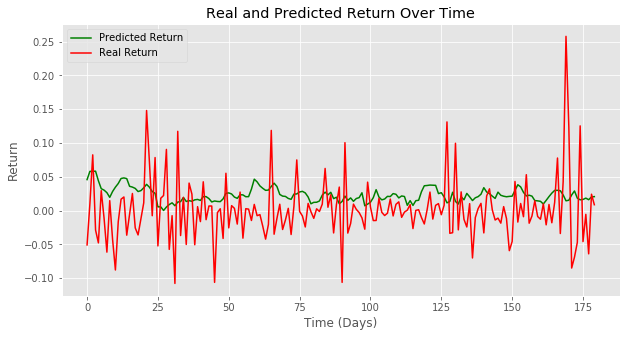

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.050767        0.045830                -10   
2018-11-26     0.010028        0.057997                  5   
2018-11-27     0.082460        0.058073                 10   
2018-11-28    -0.028790        0.058292                -10   
2018-11-29    -0.047744        0.044099                -10   
2018-11-30     0.029477        0.032422                 10   
2018-12-01    -0.011239        0.030263                 -5   
2018-12-02    -0.061434        0.026529                -10   
2018-12-03     0.014706        0.019574                  7   
2018-12-04    -0.042342        0.028224                -10   
2018-12-05    -0.087834        0.034658                -10   
2018-12-06    -0.016591        0.040055                 -8   
2018-12-07     0.016871        0.047531                  8   
2018-12-08     0.020169        0.048325                 10   
2018-12-

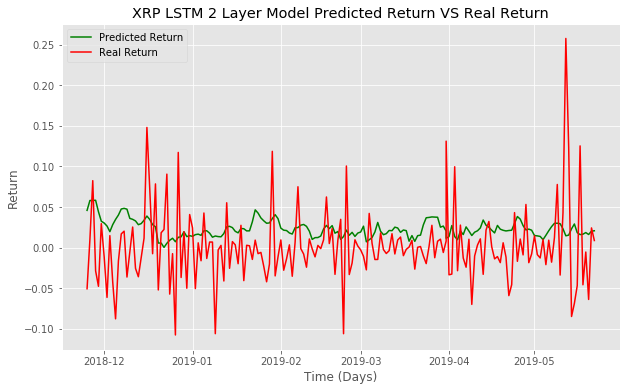

The win ratio of predicted range 0 is 0.0
The win ratio of predicted range 2 is 0.3333
The win ratio of predicted range 3 is 0.75
The win ratio of predicted range 4 is 0.5
The win ratio of predicted range 5 is 0.25
The win ratio of predicted range 6 is 0.4667
The win ratio of predicted range 7 is 0.4706
The win ratio of predicted range 8 is 0.6364
The win ratio of predicted range 9 is 0.6154
The win ratio of predicted range 10 is 0.5093


In [10]:
#Compile together
#XRP
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_XRP-USD.csv", 30, 0.8773)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("XRP LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

frequency_counts=pd.DataFrame(classification['real_y_predict_range'].value_counts(),index=None)
frequency_counts.columns=['Frequency']

#win_8,lose_8,win_ratio_8=find_win_ratio(8)    
#win_9,lose_9,win_ratio_9=find_win_ratio(9)    
#win_10,lose_10,win_ratio_10=find_win_ratio(10)    

for i in range(-10,11):
    try:
        find_win_ratio(i)
    except:
        pass

(640, 30, 112)
(640,)
(180, 30, 112)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 30, 32)            18560     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 448 samples, validate on 192 samples
Epoch 1/100
448/448 [==============================] - 2s 5ms/step - loss: 0.0506 - val_loss: 0.0146
Epoch 2/100
448/448 [==============================] - 0s 641us/step - loss: 0.0223 - val_loss: 0.0055
Epoch 3/100
448/448 [==============================] - 0s 687us/step - loss: 0.0173 - val_loss: 0.0034
Epoch 4/100
448/448 [==============================] - 0s 660us/step - loss: 0.0128 - val_loss: 0.0035
Epoch 5/100
448/448 [==============================] - 0s 653us/step - loss: 0.0114 - val_loss: 0.0040
Epoch 6/100
448/448 [==============================] - 0s 703us/step - loss: 0.0110 - val_loss: 0.0033
Epoch 7/100
448/448 [==============================] - 0s 683us/step - loss: 0.0106 - val_loss: 0.0034
Epoch 8/100
448/448 [==============================] - 0s 652us/step - loss: 0.0094 - val_loss: 0.0050
Epoch 9/100
448/448 [==============================] - 0s 617us/step - loss: 0.0100 - val_loss: 0.0033
Epoch 10/100
448/448 [=======

448/448 [==============================] - 0s 597us/step - loss: 0.0073 - val_loss: 0.0050
Epoch 80/100
448/448 [==============================] - 0s 622us/step - loss: 0.0073 - val_loss: 0.0040
Epoch 81/100
448/448 [==============================] - 0s 575us/step - loss: 0.0076 - val_loss: 0.0046
Epoch 82/100
448/448 [==============================] - 0s 599us/step - loss: 0.0071 - val_loss: 0.0052
Epoch 83/100
448/448 [==============================] - 0s 639us/step - loss: 0.0073 - val_loss: 0.0056
Epoch 84/100
448/448 [==============================] - 0s 622us/step - loss: 0.0074 - val_loss: 0.0044
Epoch 85/100
448/448 [==============================] - 0s 568us/step - loss: 0.0069 - val_loss: 0.0069
Epoch 86/100
448/448 [==============================] - 0s 613us/step - loss: 0.0073 - val_loss: 0.0050
Epoch 87/100
448/448 [==============================] - 0s 583us/step - loss: 0.0073 - val_loss: 0.0055
Epoch 88/100
448/448 [==============================] - 0s 602us/step - loss:

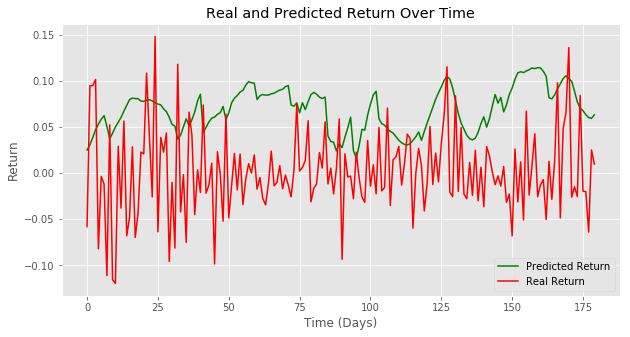

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.058028        0.025072                -10   
2018-11-26     0.094647        0.030756                 10   
2018-11-27     0.094796        0.038415                 10   
2018-11-28     0.101435        0.046940                 10   
2018-11-29    -0.081898        0.053110                -10   
2018-11-30    -0.003578        0.058300                 -1   
2018-12-01    -0.011763        0.062228                 -5   
2018-12-02    -0.111014        0.050717                -10   
2018-12-03     0.052290        0.037352                 10   
2018-12-04    -0.115457        0.043233                -10   
2018-12-05    -0.119473        0.049973                -10   
2018-12-06     0.029063        0.054932                 10   
2018-12-07    -0.037935        0.060425                -10   
2018-12-08     0.056453        0.067184                 10   
2018-12-

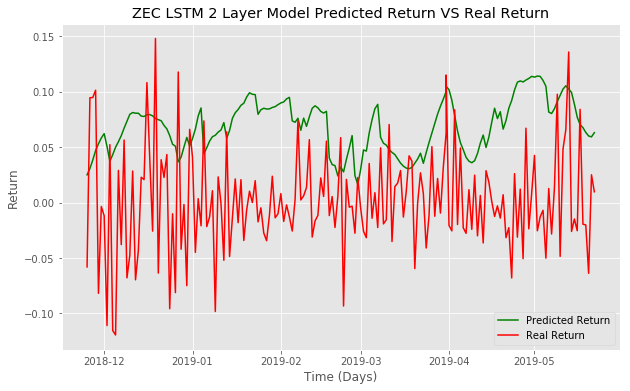

The win ratio of predicted range 8 is 0.0
The win ratio of predicted range 10 is 0.5196


In [11]:
#Compile together
#ZEC
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_ZEC-USD.csv", 30, 0.7808)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("ZEC LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

frequency_counts=pd.DataFrame(classification['real_y_predict_range'].value_counts(),index=None)
frequency_counts.columns=['Frequency']

#win_8,lose_8,win_ratio_8=find_win_ratio(8)    
#win_9,lose_9,win_ratio_9=find_win_ratio(9)    
#win_10,lose_10,win_ratio_10=find_win_ratio(10)    

for i in range(-10,11):
    try:
        find_win_ratio(i)
    except:
        pass

(2935, 30, 105)
(2935,)
(180, 30, 105)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30, 32)            17664     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 26,017
Trainable params: 26,017
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2054 samples, validate on 881 samples
Epoch 1/100
2054/2054 [==============================] - 3s 2ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 2/100
2054/2054 [==============================] - 1s 596us/step - loss: 0.0017 - val_loss: 0.0047
Epoch 3/100
2054/2054 [==============================] - 1s 585us/step - loss: 0.0014 - val_loss: 0.0039
Epoch 4/100
2054/2054 [==============================] - 1s 593us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 5/100
2054/2054 [==============================] - 1s 641us/step - loss: 9.7561e-04 - val_loss: 0.0017
Epoch 6/100
2054/2054 [==============================] - 1s 636us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/100
2054/2054 [==============================] - 1s 651us/step - loss: 8.9802e-04 - val_loss: 0.0013
Epoch 8/100
2054/2054 [==============================] - 1s 619us/step - loss: 8.8490e-04 - val_loss: 0.0017
Epoch 9/100
2054/2054 [==============================] - 1s 590us/step - loss: 8.5744e-04 - val_loss: 0

2054/2054 [==============================] - 1s 703us/step - loss: 5.6354e-04 - val_loss: 1.7133e-04
Epoch 74/100
2054/2054 [==============================] - 1s 647us/step - loss: 5.3784e-04 - val_loss: 2.0592e-04
Epoch 75/100
2054/2054 [==============================] - 1s 655us/step - loss: 5.0587e-04 - val_loss: 2.4147e-04
Epoch 76/100
2054/2054 [==============================] - 1s 647us/step - loss: 4.7108e-04 - val_loss: 1.8874e-04
Epoch 77/100
2054/2054 [==============================] - 1s 647us/step - loss: 5.6384e-04 - val_loss: 1.5990e-04
Epoch 78/100
2054/2054 [==============================] - 1s 646us/step - loss: 5.1122e-04 - val_loss: 1.6553e-04
Epoch 79/100
2054/2054 [==============================] - 1s 649us/step - loss: 4.8162e-04 - val_loss: 1.7228e-04
Epoch 80/100
2054/2054 [==============================] - 1s 659us/step - loss: 5.3046e-04 - val_loss: 1.4224e-04
Epoch 81/100
2054/2054 [==============================] - 1s 655us/step - loss: 6.5572e-04 - val_loss

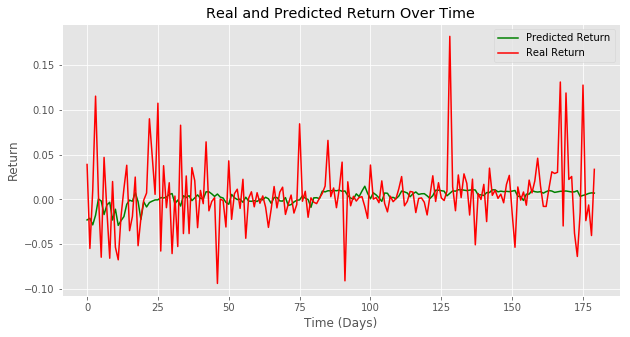

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25     0.038930       -0.023011                 10   
2018-11-26    -0.054833       -0.021143                -10   
2018-11-27     0.010146       -0.028488                  5   
2018-11-28     0.115240       -0.017757                 10   
2018-11-29     0.005427        0.000440                  2   
2018-11-30    -0.064623       -0.001801                -10   
2018-12-01     0.046834       -0.016975                 10   
2018-12-02    -0.012770       -0.006288                 -6   
2018-12-03    -0.065748       -0.003252                -10   
2018-12-04     0.019897       -0.023063                  9   
2018-12-05    -0.053416       -0.011032                -10   
2018-12-06    -0.067518       -0.029096                -10   
2018-12-07    -0.018538       -0.023691                 -9   
2018-12-08     0.011840       -0.019271                  5   
2018-12-

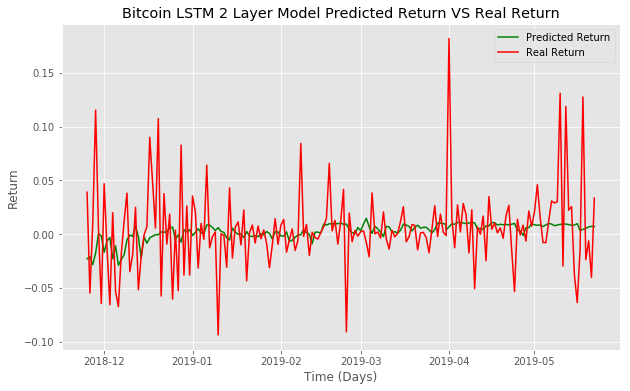

The win ratio of predicted range -10 is 0.5714
The win ratio of predicted range -9 is 0.0
The win ratio of predicted range -8 is 0.0
The win ratio of predicted range -5 is 1.0
The win ratio of predicted range -4 is 0.0
The win ratio of predicted range -3 is 0.6667
The win ratio of predicted range -2 is 0.2
The win ratio of predicted range -1 is 0.4545
The win ratio of predicted range 0 is 0.4
The win ratio of predicted range 1 is 0.4118
The win ratio of predicted range 2 is 0.4444
The win ratio of predicted range 3 is 0.55
The win ratio of predicted range 4 is 0.325
The win ratio of predicted range 5 is 0.25
The win ratio of predicted range 7 is 1.0


In [12]:
#Compile together
#Bitcoin
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("Bitcoin.csv", 30, 0.9422)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("Bitcoin LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

frequency_counts=pd.DataFrame(classification['real_y_predict_range'].value_counts(),index=None)
frequency_counts.columns=['Frequency']

#win_8,lose_8,win_ratio_8=find_win_ratio(8)    
#win_9,lose_9,win_ratio_9=find_win_ratio(9)    
#win_10,lose_10,win_ratio_10=find_win_ratio(10)    

for i in range(-10,11):
    try:
        find_win_ratio(i)
    except:
        pass